# Data Science Regression Project: Predicting Home Prices in USA

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

## realtor-data.csv (2,226,382 entries)
- brokered by (categorically encoded agency/broker)
- status (Housing status - a. ready for sale or b. ready to build)
- price (Housing price, it is either the current listing price or recently sold - price if the house is sold recently)
- bed (# of beds)
- bath (# of bathrooms)
- acre_lot (Property / Land size in acres)
- street (categorically encoded street address)
- city (city name)
- state (state name)
- zip_code (postal code of the area)
- house_size (house area/size/living space in square feet)
- prev_sold_date (Previously sold date)

https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

In [5]:
df1 = pd.read_csv('realtor-data.csv')
df1.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [6]:
df1.shape

(2226382, 12)

## Data cleaning: Unwanted data and NA values

In [8]:
# Check number of states
print(df1['state'].nunique())

df1.groupby('state')['state'].agg('count')

55


state
Alabama                  34053
Alaska                    2581
Arizona                  72825
Arkansas                 23045
California              227215
Colorado                 32293
Connecticut              14008
Delaware                  8628
District of Columbia      6625
Florida                 249432
Georgia                  80977
Guam                       489
Hawaii                    7243
Idaho                    16760
Illinois                 85280
Indiana                  18840
Iowa                     23033
Kansas                   14858
Kentucky                 26316
Louisiana                25815
Maine                     5065
Maryland                 46052
Massachusetts            38041
Michigan                 42429
Minnesota                43412
Mississippi              16255
Missouri                 45145
Montana                  10059
Nebraska                  6309
Nevada                   14667
New Brunswick                1
New Hampshire             3642
Ne

In [9]:
# There's only 50 U.S. states, we are not interested in U.S. territories or Canadian states
# Use a list of the 50 U.S. states to filter out the rest
us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
    'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 
    'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 
    'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

df2 = df1[df1['state'].isin(us_states)]

# Validate
print(df2['state'].nunique())

50


In [10]:
# Limit the location to state for dimensionality reduction
df3 = df2.drop(['brokered_by', 'status', 'prev_sold_date', 'street', 'city', 'zip_code'], axis = 'columns')
df3.head()

,price,bed,bath,acre_lot,state,house_size
3403,180000.0,2.0,1.0,0.34,Massachusetts,676.0
3404,25000.0,NaN,NaN,3.41,Massachusetts,NaN
3405,169900.0,2.0,2.0,NaN,Massachusetts,892.0
3406,242000.0,2.0,2.0,NaN,Massachusetts,1428.0
3407,299950.0,2.0,2.0,NaN,Massachusetts,1659.0


In [11]:
df3.isnull().sum()

price           1541
bed           479565
bath          510144
acre_lot      320976
state              0
house_size    566758
dtype: int64

In [12]:
# Not the best practice but for simplicity's sake
df4 = df3.dropna()
df4.isnull().sum()
df4 = df4[df4['price'] != 0]

In [13]:
df4.shape

(1355972, 6)

## Outlier Removal

In [15]:
df4['bed'].unique()

array([  2.,   3.,   4.,   6.,   5.,   8.,   1.,   7.,   9.,  10.,  12.,
        24.,  28.,  14.,  13.,  18.,  11.,  20.,  16.,  15.,  19.,  17.,
        33.,  40.,  21.,  86.,  31.,  27.,  42.,  60.,  22.,  32.,  99.,
        49.,  30.,  23.,  47.,  36.,  38.,  25.,  64.,  75.,  70.,  26.,
        29.,  34.,  54.,  72., 100.,  62.,  73.,  52., 102.,  37.,  69.,
        82.,  41.,  76.,  66.,  50.,  48.,  43.,  35., 190.,  93.,  45.,
        96.,  74.,  57.,  39.,  55.,  56.,  61.,  63.,  44.,  46.,  90.,
       108., 212.,  71., 444., 148.,  84.,  80.])

In [16]:
# Some rows contain a ridiculous number of bedrooms
# but they do not match the house size, likely errors
df4[df4.bed>100]

,price,bed,bath,acre_lot,state,house_size
690428,1499000.0,102.0,99.0,0.50,Ohio,7773.0
957227,189000.0,190.0,163.0,3.57,Louisiana,110350.0
1281369,18000000.0,108.0,108.0,4.92,California,65960.0
1370041,1695000.0,212.0,212.0,0.34,Washington,5908.0
1379204,440000.0,444.0,222.0,0.34,Oregon,1700.0
1382122,549000.0,148.0,74.0,0.23,Oregon,3372.0
2188928,430000.0,444.0,222.0,0.34,Oregon,1700.0


In [17]:
# Function to remove number of bedroom outliers
# per state by one std from mean
def remove_bed_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('state'):
        m = np.mean(subdf.bed)
        st = np.std(subdf.bed)
        reduced_df = subdf[(subdf.bed>(m-st)) & (subdf.bed<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [18]:
df5 = remove_bed_outliers(df4)
df5['bed'].unique()

array([4., 3., 6., 2., 5., 1., 7.])

In [19]:
df5['bath'].unique()

array([  4.,   2.,   1.,   3.,   5.,   6.,   7.,   8.,  10.,  20.,  19.,
        29.,   9.,  14.,  11.,  16.,  24.,  25.,  12., 113.])

In [20]:
# Function to remove number of bathroom outliers
# per state by one std from mean
def remove_bath_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('state'):
        m = np.mean(subdf.bath)
        st = np.std(subdf.bath)
        reduced_df = subdf[(subdf.bath>(m-st)) & (subdf.bath<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [21]:
df5 = remove_bath_outliers(df4)
df5['bath'].unique()

array([2., 3., 4., 1., 5.])

In [22]:
# Function to remove price outliers
# per state by one std from mean
def remove_price_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('state'):
        m = np.mean(subdf.price)
        st = np.std(subdf.price)
        reduced_df = subdf[(subdf.price>(m-st)) & (subdf.price<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [23]:
df5 = remove_price_outliers(df5)

In [24]:
df5['price_per_sqft'] = df5['price']/df5['house_size']
df5.head()

,price,bed,bath,acre_lot,state,house_size,price_per_sqft
0,175000.0,3.0,2.0,0.77,Alabama,1234.0,141.815235
1,279000.0,3.0,2.0,0.49,Alabama,1917.0,145.539906
2,320000.0,3.0,3.0,0.90,Alabama,2348.0,136.286201
3,400000.0,3.0,2.0,1.13,Alabama,1807.0,221.361372
4,139900.0,4.0,3.0,3.00,Alabama,1960.0,71.377551


In [25]:
# 300 sq ft is a realistic average for 1 bedroom
# The below are considered outliers
df5[df5.house_size/df5.bed<300].head()

,price,bed,bath,acre_lot,state,house_size,price_per_sqft
30,99999.0,5.0,2.0,3.75,Alabama,1345.0,74.348699
252,250000.0,3.0,2.0,10.00,Alabama,828.0,301.932367
370,140000.0,3.0,2.0,1.00,Alabama,880.0,159.090909
1239,124900.0,3.0,2.0,12.00,Alabama,868.0,143.894009
1430,79500.0,3.0,2.0,1.20,Alabama,744.0,106.854839


In [26]:
df5.shape

(985137, 7)

In [27]:
df6 = df5[~(df5.house_size/df5.bed<300)]
df6.shape

(975250, 7)

In [28]:
df6.price_per_sqft.describe()

count    975250.000000
mean        249.498210
std         194.612081
min           0.000344
25%         143.606322
50%         195.833333
75%         284.069001
max        8714.285714
Name: price_per_sqft, dtype: float64

In [29]:
# Function to remove price per sqft outliers
# per state by one std from mean
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('state'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [30]:
df7 = remove_pps_outliers(df6)
df7.shape

(739865, 7)

In [31]:
df7.price_per_sqft.describe()

count    739865.000000
mean        233.788051
std         132.874118
min          39.251208
25%         149.950000
50%         194.545151
75%         270.197967
max        1017.214397
Name: price_per_sqft, dtype: float64

In [32]:
def plot_scatter_chart(df, state):
    twoBed = df[(df.state == state) & (df.bed == 2)]
    threeBed = df[(df.state == state) & (df.bed == 3)]
    matplotlib.rcParams['figure.figsize'] = (15, 10)
    plt.scatter(twoBed.house_size, twoBed.price, color = 'blue', label = '2 bedrooms', s = 50)
    plt.scatter(threeBed.house_size, threeBed.price, marker = '+', color = 'green', label = '3 bedrooms', s = 50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price Per Square Feet")
    plt.title(state)
    plt.legend()
    plt.show()

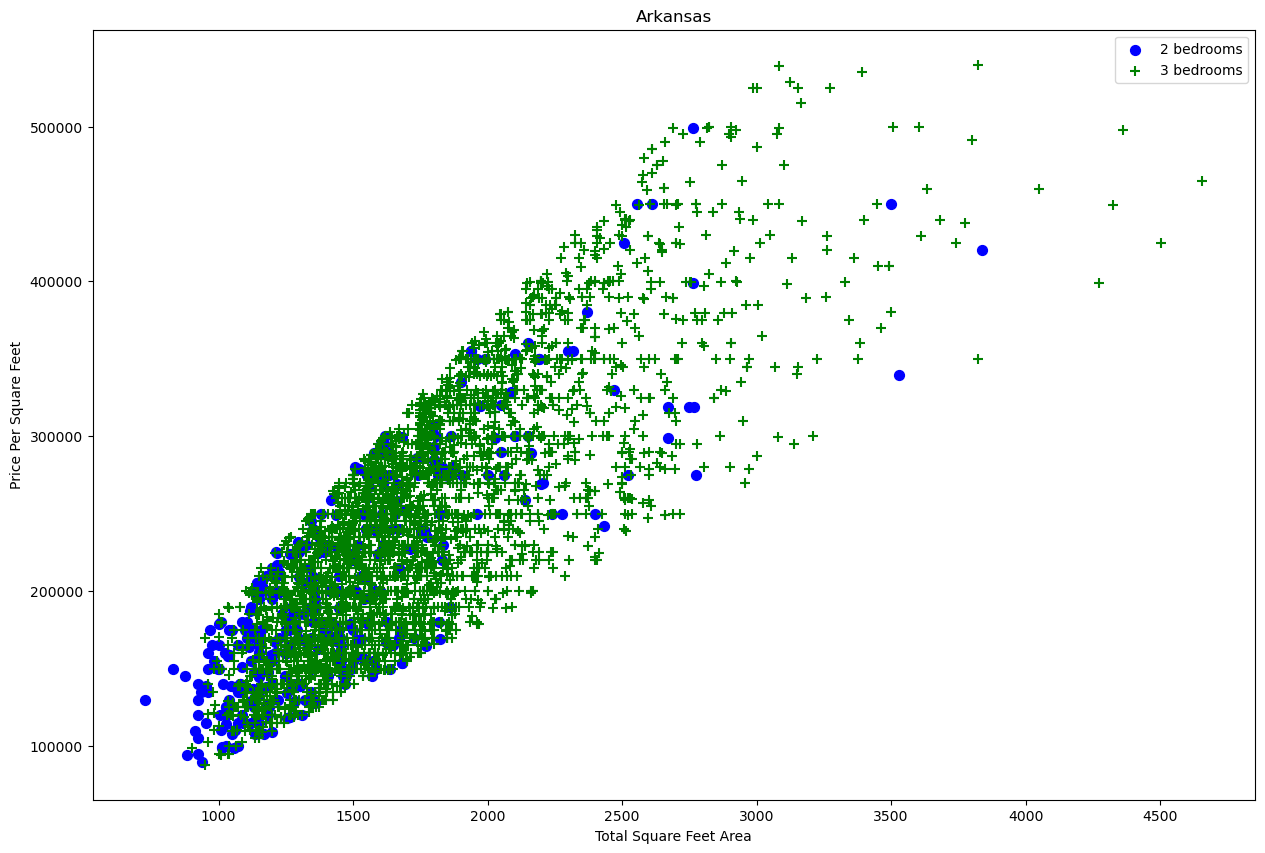

In [33]:
plot_scatter_chart(df7, 'Arkansas')

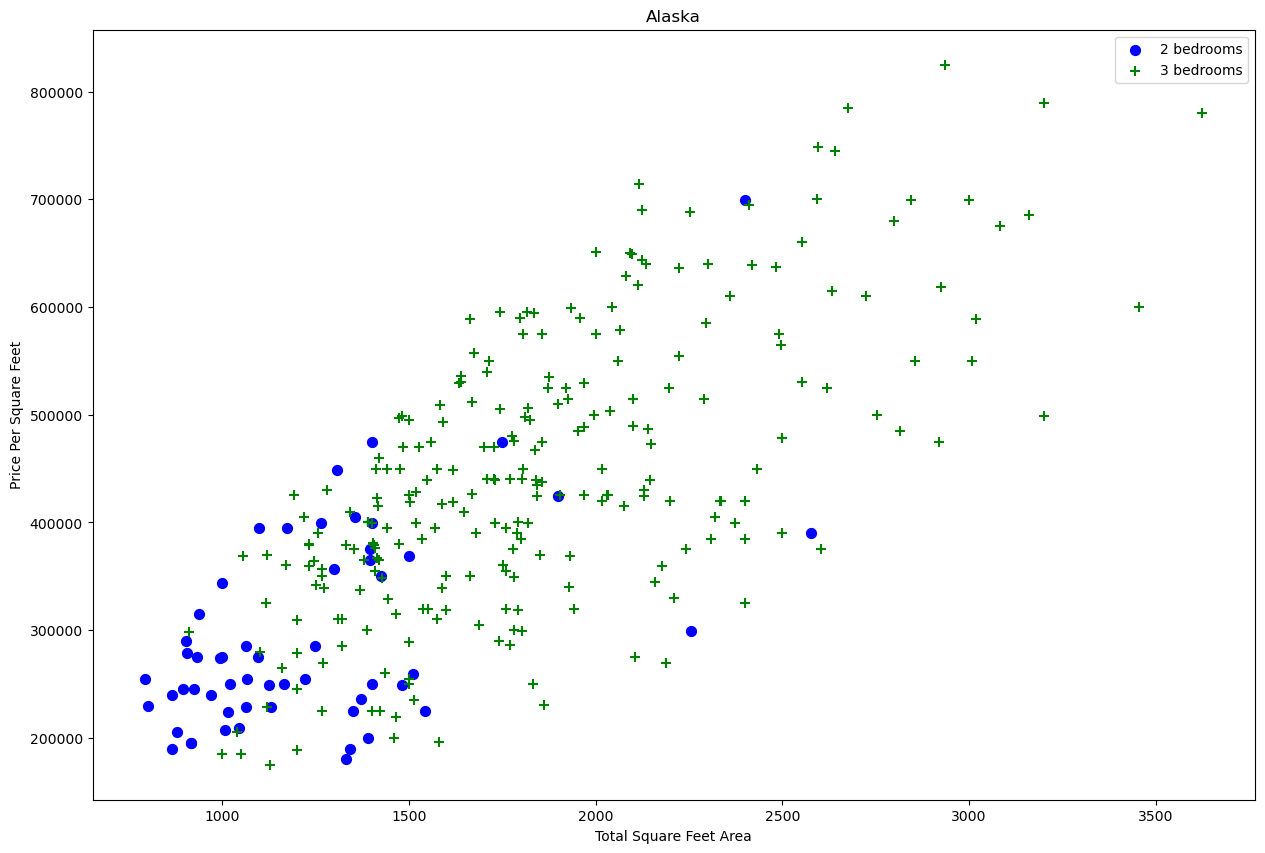

In [34]:
plot_scatter_chart(df7, 'Alaska')

In [35]:
# Remove bedroom outliers (same state, but 2 bed price is higher than 3 bed, etc.)
def remove_bed_outliers_by_number(df):
    exclude_indices = np.array([])
    for state, state_df in df.groupby('state'):
        bed_stats = {}
        for bed, bed_df in state_df.groupby('bed'):
            bed_stats[bed] = {
                'mean': np.mean(bed_df.price_per_sqft),
                'std': np.std(bed_df.price_per_sqft),
                'count': bed_df.shape[0]
            }
        for bed, bed_df in state_df.groupby('bed'):
            stats = bed_stats.get(bed-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bed_df[bed_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df8 = remove_bed_outliers_by_number(df7)
df8.shape

(321162, 7)

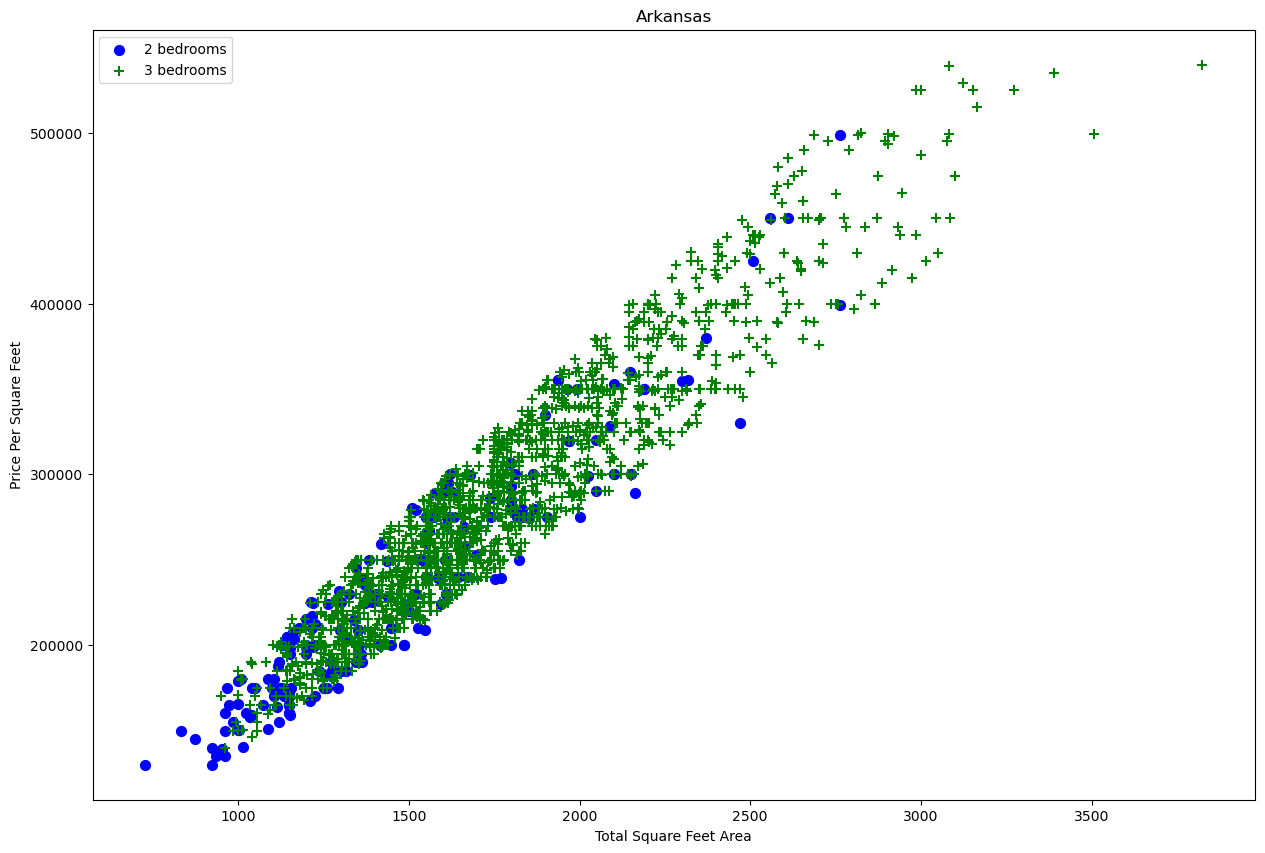

In [36]:
plot_scatter_chart(df8, 'Arkansas')

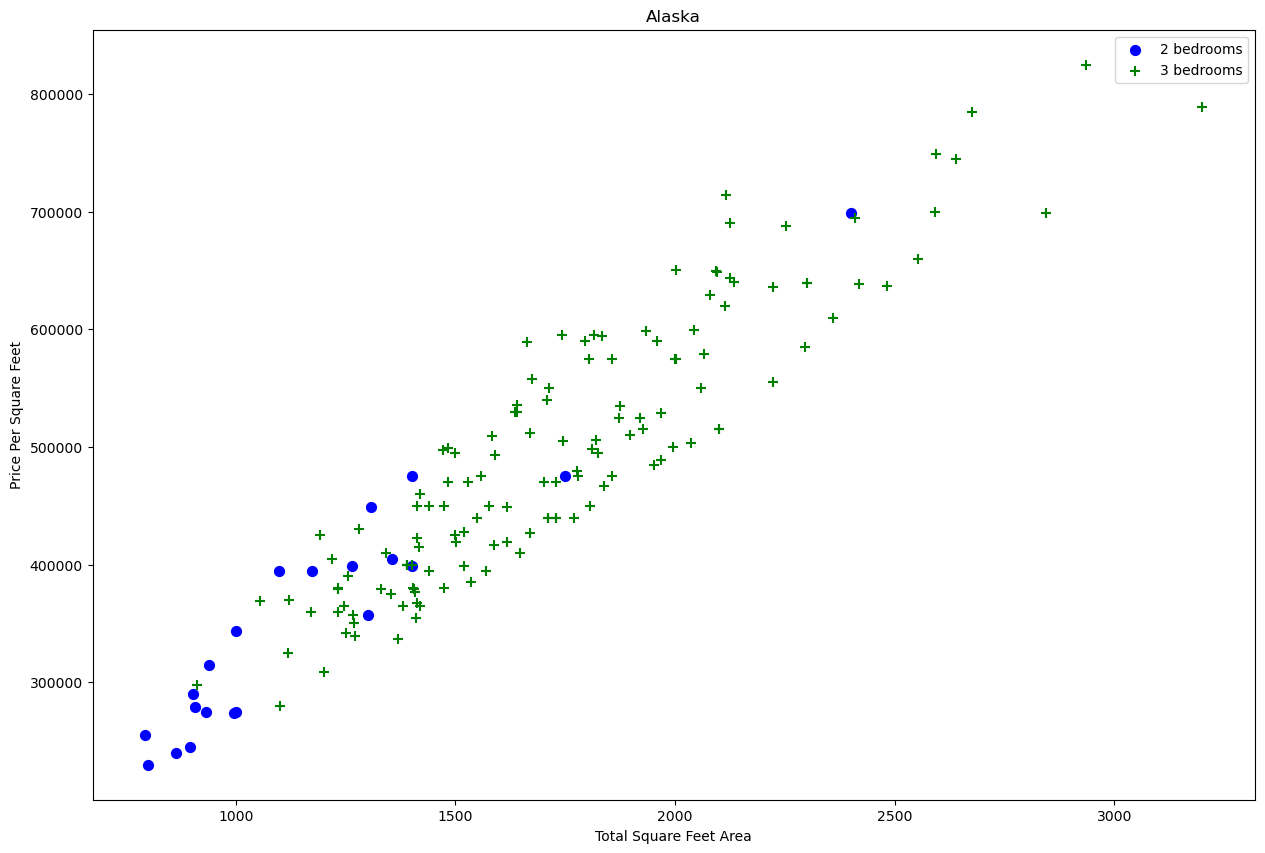

In [37]:
plot_scatter_chart(df8, 'Alaska')

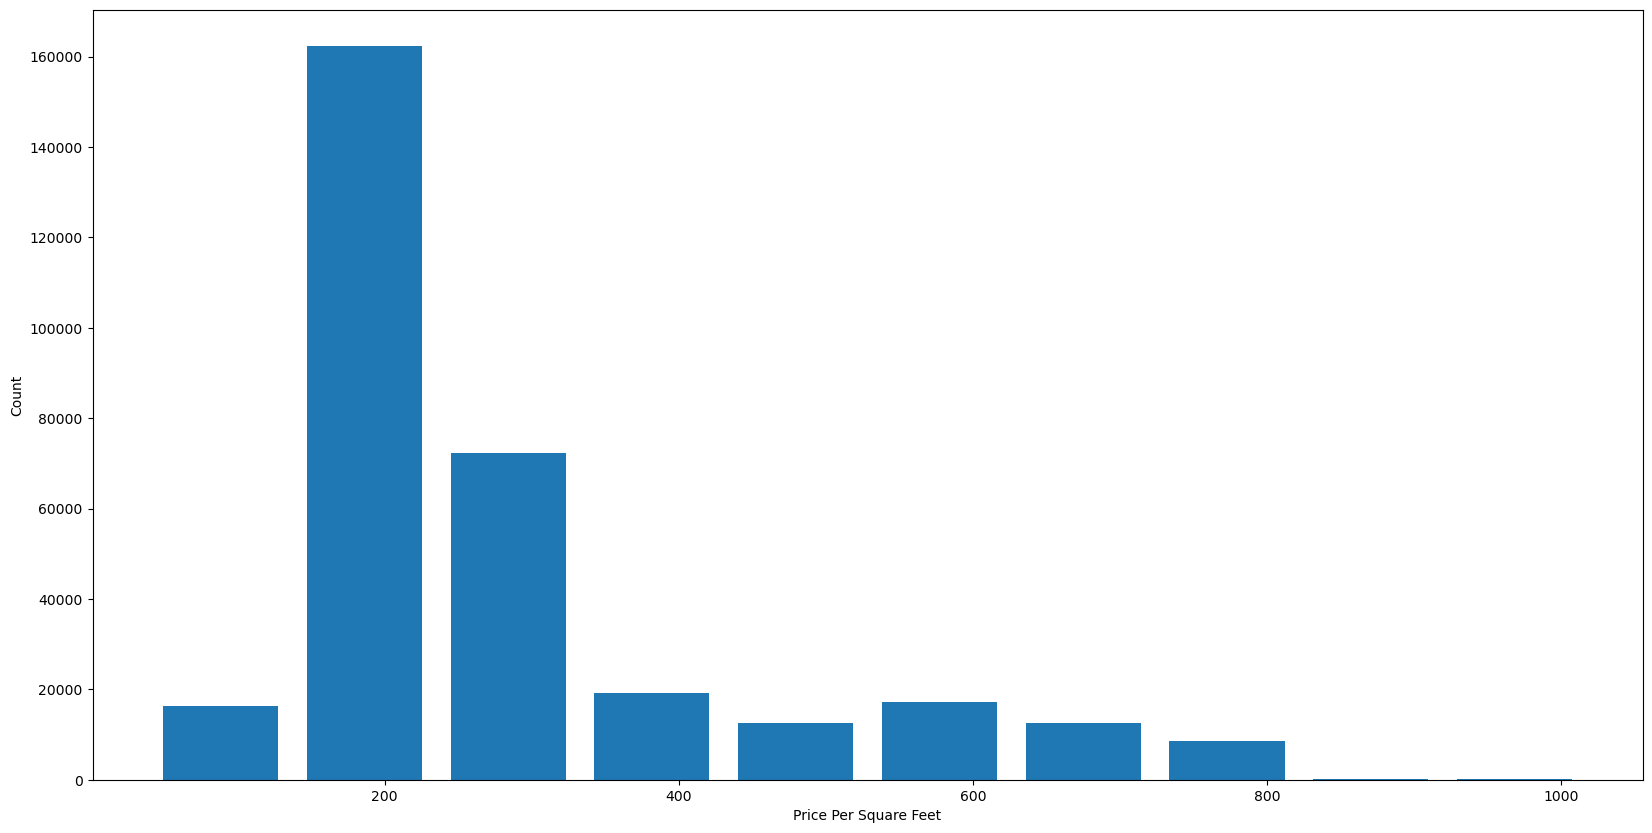

In [38]:
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.show()

In [39]:
df8.bath.unique()

array([2., 3., 4., 1., 5.])

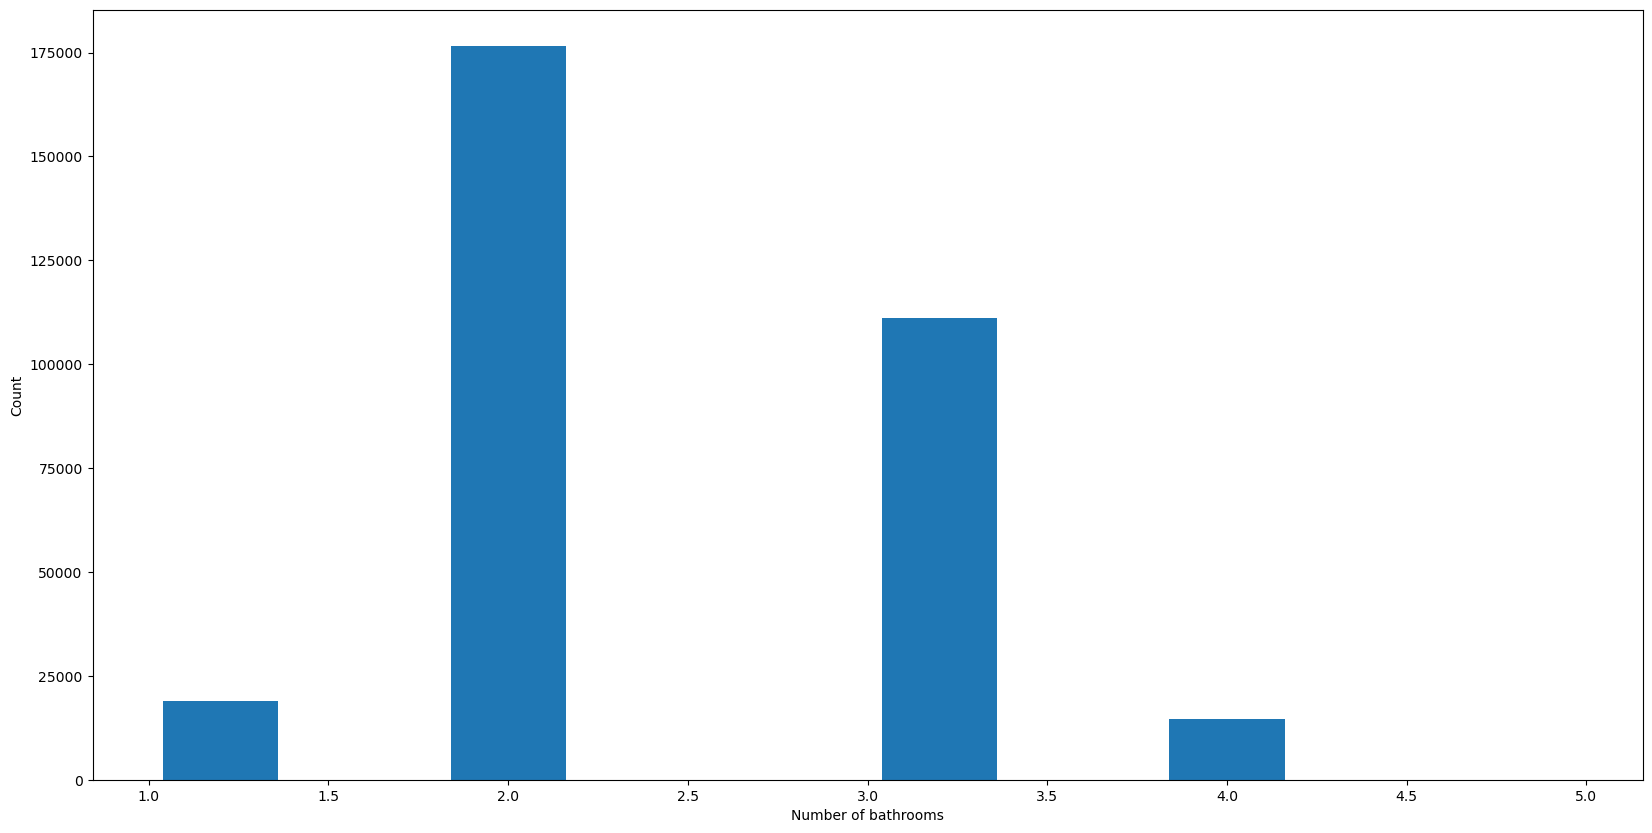

In [40]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")
plt.show()

In [41]:
# Unlikely for a house to have 2 more baths than bedrooms
df8[df8.bath>df8.bed+2]

,price,bed,bath,acre_lot,state,house_size,price_per_sqft
93993,849000.0,1.0,4.0,0.14,California,1600.0,530.625000
184267,425000.0,1.0,4.0,1.00,Connecticut,2820.0,150.709220
456756,1199000.0,1.0,4.0,0.76,New York,8000.0,149.875000
470167,199900.0,1.0,4.0,0.12,New York,4320.0,46.273148
676004,1185000.0,1.0,4.0,0.25,Utah,6138.0,193.059629


In [42]:
df9 = df8[df8.bath<df8.bed+2]
df9.shape

(320947, 7)

In [43]:
df9.price_per_sqft.describe()

count    320947.000000
mean        283.057301
std         160.315894
min          39.529915
25%         179.614349
50%         220.841960
75%         309.956705
max        1017.214397
Name: price_per_sqft, dtype: float64

In [44]:
df9.head()

,price,bed,bath,acre_lot,state,house_size,price_per_sqft
0,175000.0,3.0,2.0,0.77,Alabama,1234.0,141.815235
1,279000.0,3.0,2.0,0.49,Alabama,1917.0,145.539906
2,320000.0,3.0,3.0,0.90,Alabama,2348.0,136.286201
4,169900.0,2.0,2.0,0.20,Alabama,1088.0,156.158088
5,349900.0,3.0,2.0,23.00,Alabama,2520.0,138.849206


In [45]:
# price per sqft is unnecessary at this point
df10 = df9.drop(['price_per_sqft'],axis='columns')
df10.head()

,price,bed,bath,acre_lot,state,house_size
0,175000.0,3.0,2.0,0.77,Alabama,1234.0
1,279000.0,3.0,2.0,0.49,Alabama,1917.0
2,320000.0,3.0,3.0,0.90,Alabama,2348.0
4,169900.0,2.0,2.0,0.20,Alabama,1088.0
5,349900.0,3.0,2.0,23.00,Alabama,2520.0
